Import necessary libreries

In [11]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import keras
from vit_keras import vit, utils
from vit_keras import vit, utils, visualize

In [3]:
path='Dataset'
train_dir='Dataset/Train'
test_dir='Dataset/Val'
print(len(os.listdir(train_dir)))

2


(1161, 1170, 3)


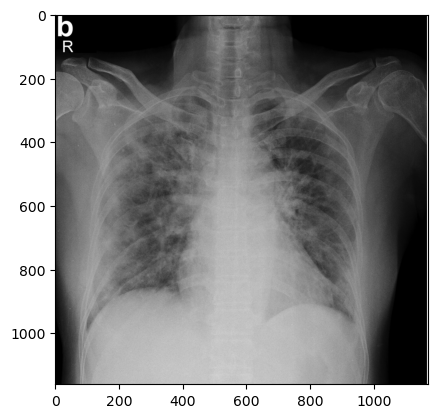

In [6]:
path_1='Dataset/Train/Covid/'
img=path_1+'1-s2.0-S0929664620300449-gr2_lrg-b.jpg'
img=mpimg.imread(img)
print(img.shape)
plt.imshow(img,cmap='gray')

(1237, 1156)


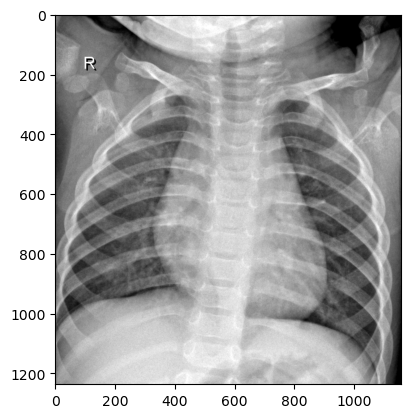

In [5]:
img_2='Dataset/Train/Normal/IM-0140-0001.jpeg'
img_2=mpimg.imread(img_2)
print(img_2.shape)
plt.imshow(img_2,cmap="gray")

In [12]:
def re_size(x):
    img=mpimg.imread(x)
    resized_image=cv2.resize(img,(150,150,3))
    return(resized_img)

In [13]:
train_gen=ImageDataGenerator(rescale=1/255,rotation_range=20,
                               width_shift_range=0.10,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode='nearest')
valid_gen=ImageDataGenerator(rescale=1./255)

In [14]:
img_width=150
img_height=150
channel=3
image_shape=(img_height,img_width,channel)
train=train_gen.flow_from_directory(train_dir,target_size=[150,150],color_mode='rgb',batch_size=16,class_mode='binary',shuffle=True)
valid=valid_gen.flow_from_directory(test_dir,target_size=[150,150],color_mode='rgb',batch_size=16,class_mode='binary',shuffle=True)

Found 288 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


Model 1 (Convolution Neural Network)

In [15]:
model=tf.keras.Sequential([
                          tf.keras.layers.Conv2D(32,(3,3),input_shape=image_shape,activation='relu'),
                          tf.keras.layers.MaxPooling2D((2,2)),
                          tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
                          tf.keras.layers.MaxPooling2D((2,2)),
                          tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
                          tf.keras.layers.MaxPooling2D((2,2)),
                          tf.keras.layers.Flatten(),
                          tf.keras.layers.Dense(128,activation='relu'),
                          tf.keras.layers.Dense(1,activation='sigmoid')])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 32)        0

In [16]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)

In [17]:
epochs=15
history=model.fit(train,epochs=15,validation_data=valid,callbacks=[early_stop])

Epoch 1/15
18/18 [==============================] - 26s 1s/step - loss: 0.6767 - accuracy: 0.5938 - val_loss: 0.4693 - val_accuracy: 0.9333
Epoch 2/15
18/18 [==============================] - 21s 1s/step - loss: 0.3115 - accuracy: 0.9062 - val_loss: 0.1919 - val_accuracy: 0.9167
Epoch 3/15
18/18 [==============================] - 22s 1s/step - loss: 0.2406 - accuracy: 0.9167 - val_loss: 0.1575 - val_accuracy: 0.9500
Epoch 4/15
18/18 [==============================] - 21s 1s/step - loss: 0.2176 - accuracy: 0.9097 - val_loss: 0.1060 - val_accuracy: 0.9500
Epoch 5/15
18/18 [==============================] - 26s 1s/step - loss: 0.1812 - accuracy: 0.9201 - val_loss: 0.1408 - val_accuracy: 0.9333
Epoch 6/15
18/18 [==============================] - 30s 2s/step - loss: 0.1640 - accuracy: 0.9340 - val_loss: 0.1365 - val_accuracy: 0.9500
Epoch 7/15
18/18 [==============================] - 29s 2s/step - loss: 0.1544 - accuracy: 0.9236 - val_loss: 0.1575 - val_accuracy: 0.9500
Epoch 8/15
18/18 [==

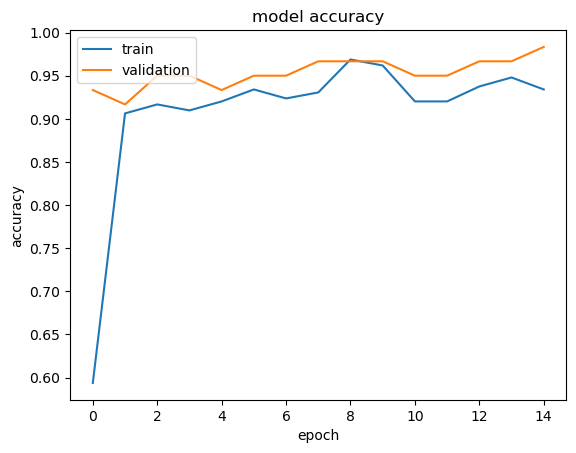

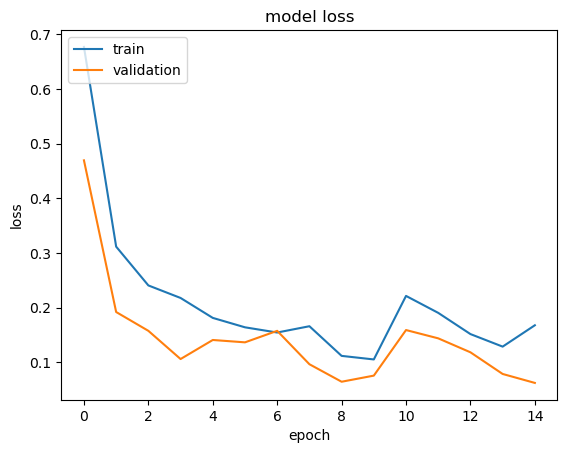

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [20]:
model.save('CNN2D.h5')

c:\Users\mahan\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
from sklearn import metrics

4/4 [==============================] - 4s 863ms/step


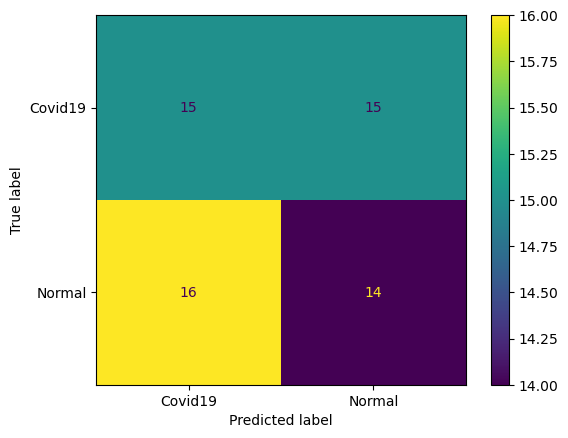

In [31]:
prediction=model.predict(valid)
prediction = np.where(prediction>=0.5,1, 0).tolist()
confusion_matrix = metrics.confusion_matrix(valid.labels, prediction)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Covid19','Normal'])

cm_display.plot()
plt.show()

Model 2 (Vision Transformer)

In [49]:
from tensorflow.keras.optimizers import Adam

In [102]:
image_size = 224
model = vit.vit_b32(
    image_size=image_size,
    activation='sigmoid',
    pretrained=True,
    include_top=False,
    pretrained_top=False,
    classes = 2)

c:\Users\mahan\anaconda3\Lib\site-packages\vit_keras\utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


In [103]:
model.summary()

Model: "vit-b32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 7, 7, 768)         2360064   
                                                                 
 reshape_7 (Reshape)         (None, 49, 768)           0         
                                                                 
 class_token (ClassToken)    (None, 50, 768)           768       
                                                                 
 Transformer/posembed_input  (None, 50, 768)           38400     
  (AddPositionEmbs)                                              
                                                                 
 Transformer/encoderblock_0  ((None, 50, 768),         7087872   
  (TransformerBlock)          (None, 12, None, None)       

In [115]:
model = tf.keras.Sequential([
        model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128,activation='relu'),
        tf.keras.layers.Dense(1,activation='sigmoid')
    ],
    name = 'vision_transformer')

# Compile the model
learning_rate = 0.001  # Adjust the learning rate as needed
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

In [116]:
model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vision_transformer (Sequen  (None, 1)                 87467395  
 tial)                                                           
                                                                 
 flatten_22 (Flatten)        (None, 1)                 0         
                                                                 
 dense_42 (Dense)            (None, 128)               256       
                                                                 
 dense_43 (Dense)            (None, 1)                 129       
                                                                 
Total params: 87467780 (333.66 MB)
Trainable params: 87466172 (333.66 MB)
Non-trainable params: 1608 (6.28 KB)
_________________________________________________________________


In [117]:
# Train the fine-tuned model
model.fit(train, validation_data=valid, epochs=10,callbacks=[early_stop])

Epoch 1/10
18/18 [==============================] - 203s 9s/step - loss: 0.6945 - accuracy: 0.4236 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/10
18/18 [==============================] - 152s 8s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/10
18/18 [==============================] - 154s 9s/step - loss: 0.6935 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/10
18/18 [==============================] - 156s 9s/step - loss: 0.6937 - accuracy: 0.4688 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/10
18/18 [==============================] - 169s 9s/step - loss: 0.6926 - accuracy: 0.5139 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/10
18/18 [==============================] - 166s 9s/step - loss: 0.6910 - accuracy: 0.5000 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 7/10
18/18 [==============================] - 164s 9s/step - loss: 0.6874 - accuracy: 0.5000 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 8/10
18

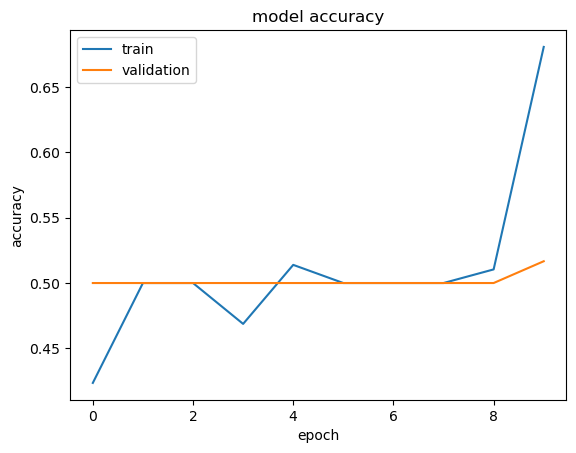

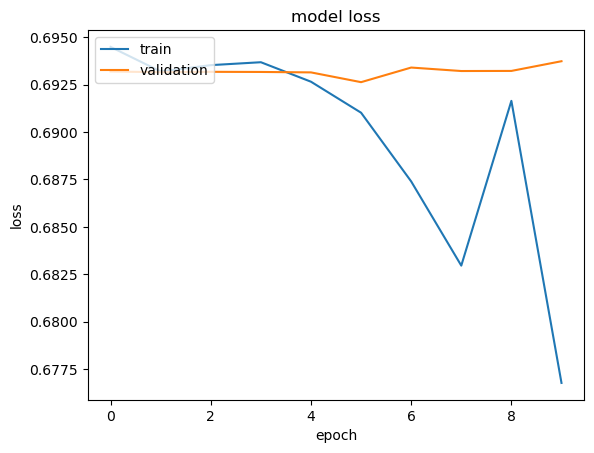

In [120]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

4/4 [==============================] - 14s 2s/step


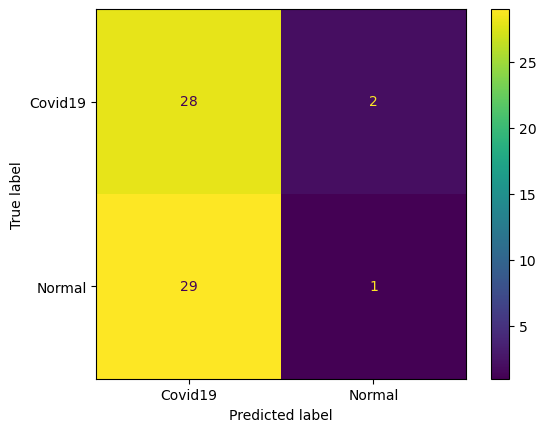

In [122]:
prediction=model.predict(valid)
prediction = np.where(prediction>=0.5,1, 0).tolist()
confusion_matrix = metrics.confusion_matrix(valid.labels, prediction)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Covid19','Normal'])

cm_display.plot()
plt.show()

In [123]:
model.save('VIT.h5')

c:\Users\mahan\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
url = 'Dataset/Train/Covid/1-s2.0-S0929664620300449-gr2_lrg-b.jpg'
image = utils.read(url, image_size)
attention_map = visualize.attention_map(model=model, image=image)

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original image')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)

Model3 (VGG16)

In [160]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from keras.applications.vgg16 import VGG16

In [168]:
base_model = VGG16(weights='models/base_VGG16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(150,150, 3))


for layer in base_model.layers:
    layer.trainable = False

x = GlobalMaxPooling2D()(base_model.output)
x = Dense(2048, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
vgg16_model = Model(base_model.input, output,name='VGG16')
vgg16_model.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [169]:
from tensorflow.keras.callbacks import EarlyStopping
learning_rate = 0.00001  
decay_steps = 10         
decay_rate = 1           

lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate, decay_steps, decay_rate)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

vgg16_model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

history = vgg16_model.fit(train, batch_size=32, epochs=10, validation_data=valid, callbacks=[early_stop])

Epoch 1/10
18/18 [==============================] - 140s 8s/step - loss: 0.6485 - accuracy: 0.6562 - val_loss: 0.5970 - val_accuracy: 0.9167
Epoch 2/10
18/18 [==============================] - 131s 7s/step - loss: 0.5679 - accuracy: 0.9410 - val_loss: 0.5231 - val_accuracy: 0.9167
Epoch 3/10
18/18 [==============================] - 125s 7s/step - loss: 0.5030 - accuracy: 0.9236 - val_loss: 0.4614 - val_accuracy: 0.9167
Epoch 4/10
18/18 [==============================] - 131s 7s/step - loss: 0.4504 - accuracy: 0.9583 - val_loss: 0.4096 - val_accuracy: 0.9333
Epoch 5/10
18/18 [==============================] - 128s 7s/step - loss: 0.3963 - accuracy: 0.9514 - val_loss: 0.3647 - val_accuracy: 0.9333
Epoch 6/10
18/18 [==============================] - 133s 7s/step - loss: 0.3625 - accuracy: 0.9653 - val_loss: 0.3242 - val_accuracy: 0.9333
Epoch 7/10
18/18 [==============================] - 128s 7s/step - loss: 0.3139 - accuracy: 0.9549 - val_loss: 0.2895 - val_accuracy: 0.9500
Epoch 8/10
18

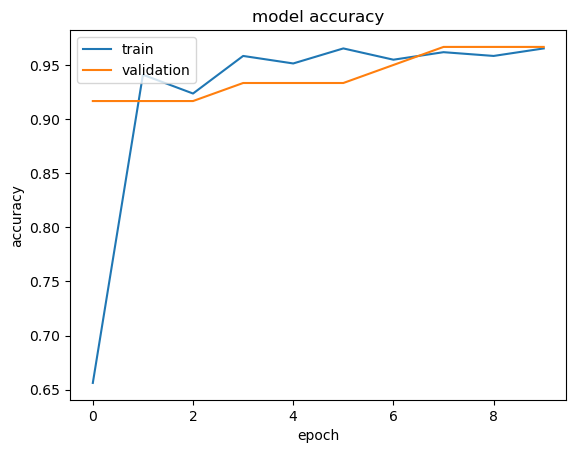

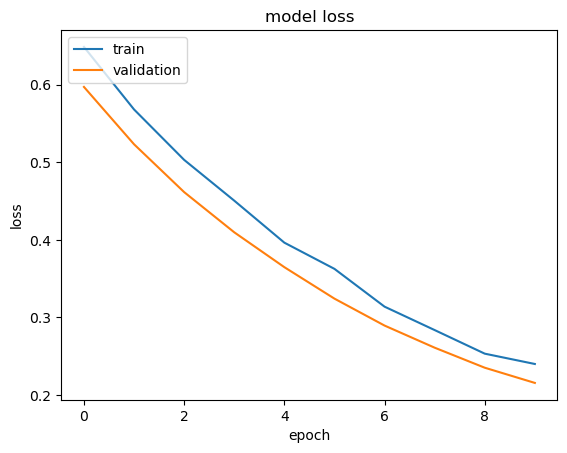

In [170]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

4/4 [==============================] - 22s 5s/step


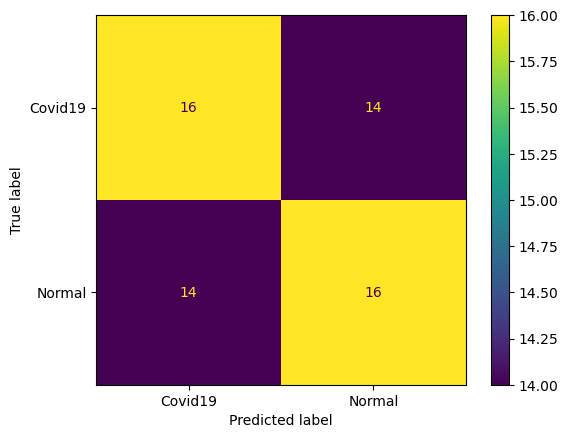

In [172]:
prediction=vgg16_model.predict(valid)
prediction = np.where(prediction>=0.5,1, 0).tolist()
confusion_matrix = metrics.confusion_matrix(valid.labels, prediction)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Covid19','Normal'])

cm_display.plot()
plt.show()

In [173]:
model.save('VGG16.h5')

c:\Users\mahan\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
